- Boundary train data collected in a [100, 2] numpy array: pairs of (x, t)
- Boundary solution data collected in a [100, 2] numpy array
- Collocation points come in a [10100, 2] numpy array: paris of (x, t)
- These arrays are passed to the PINN
- These arrays are transformed into torch tensors
- The net is created manualy, although you should better inherit from torch.nn.Module
- The net takes a two-input vector and returns a one-output vector
- LBFGS is used to update the net's gradients (this is a full-batch prodecure)
- Xavier initialization didn't work out for me, so I left it alone
- The net represents the u function, f is a function of the net
- f is the differential equation equaled to zero
- Both the boundary conditions and the PDE losses (u_loss and f_loss) are added together
- The sum of these two losses is the minimized using the torch.optimizer

In [1]:
import torch
import torch.nn as nn
import numpy as np
from random import uniform

In [2]:
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f):
        # x & t from boundary conditions:
        self.x_u = torch.tensor(X_u[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_u = torch.tensor(X_u[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)

        # x & t from collocation points:
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)

        # boundary solution:
        self.u = torch.tensor(u, dtype=torch.float32)

        # null vector to test against f:
        self.null =  torch.zeros((self.x_f.shape[0], 1))

        # initialize net:
        self.create_net()
        #self.net.apply(self.init_weights)

        # this optimizer updates the weights and biases of the net:
        self.optimizer = torch.optim.LBFGS(self.net.parameters(),
                                    lr=1,
                                    max_iter=50000,
                                    max_eval=50000,
                                    history_size=50,
                                    tolerance_grad=1e-05,
                                    tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")

        # typical MSE loss (this is a function):
        self.loss = nn.MSELoss()

        # loss :
        self.ls = 0

        # iteration number:
        self.iter = 0

    def create_net(self):
        """ net takes a batch of two inputs: (n, 2) --> (n, 1) """
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1))

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight, 0.1)
            m.bias.data.fill_(0.001)
        
    def net_u(self, x, t):
        u = self.net( torch.hstack((x, t)) )
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        f = u_t + (u * u_x) - (nu * u_xx)

        return f

    def plot(self):
        """ plot the solution on new data """
        
        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        x = torch.linspace(-1, 1, 200)
        t = torch.linspace( 0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        # one large column:
        usol = self.net_u(xcol, tcol)

        # reshape solution:
        U = usol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow', 
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()

    def closure(self):
        # reset gradients to zero:
        self.optimizer.zero_grad()
        
        # u & f predictions:
        u_prediction = self.net_u(self.x_u, self.t_u)
        f_prediction = self.net_f(self.x_f, self.t_f)

        # losses:
        u_loss = self.loss(u_prediction, self.u)
        f_loss = self.loss(f_prediction, self.null)
        self.ls = u_loss + f_loss

        # derivative with respect to net's weights:
        self.ls.backward()

        # increase iteration count:
        self.iter += 1

        # print report:
        if not self.iter % 100:
            print('Epoch: {0:}, Loss: {1:f}'.format(self.iter, self.ls))

        return self.ls
        
    def train(self):
        """ training loop """
        self.net.train()
        self.optimizer.step(self.closure)

In [3]:
if __name__ == '__main__' :

    nu = 0.01 / np.pi         # constant in the diff. equation
    N_u = 100                 # number of data points in the boundaries
    N_f = 10000               # number of collocation points

    # X_u_train: a set of pairs (x, t) located at:
        # x =  1, t = [0,  1]
        # x = -1, t = [0,  1]
        # t =  0, x = [-1, 1]
    x_upper = np.ones((N_u//4, 1), dtype=float)
    x_lower = np.ones((N_u//4, 1), dtype=float) * (-1)
    t_zero = np.zeros((N_u//2, 1), dtype=float)

    t_upper = np.random.rand(N_u//4, 1)
    t_lower = np.random.rand(N_u//4, 1)
    x_zero = (-1) + np.random.rand(N_u//2, 1) * (1 - (-1))

    # stack uppers, lowers and zeros:
    X_upper = np.hstack( (x_upper, t_upper) )
    X_lower = np.hstack( (x_lower, t_lower) )
    X_zero = np.hstack( (x_zero, t_zero) )

    # each one of these three arrays haS 2 columns, 
    # now we stack them vertically, the resulting array will also have 2 
    # columns and 100 rows:
    X_u_train = np.vstack( (X_upper, X_lower, X_zero) )

    # shuffle X_u_train:
    index = np.arange(0, N_u)
    np.random.shuffle(index)
    X_u_train = X_u_train[index, :]
    
    # make X_f_train:
    X_f_train = np.zeros((N_f, 2), dtype=float)
    for row in range(N_f):
        x = uniform(-1, 1)  # x range
        t = uniform( 0, 1)  # t range

        X_f_train[row, 0] = x 
        X_f_train[row, 1] = t

    # add the boundary points to the collocation points:
    X_f_train = np.vstack( (X_f_train, X_u_train) )

    # make u_train
    u_upper =  np.zeros((N_u//4, 1), dtype=float)
    u_lower =  np.zeros((N_u//4, 1), dtype=float) 
    u_zero = -np.sin(np.pi * x_zero)  

    # stack them in the same order as X_u_train was stacked:
    u_train = np.vstack( (u_upper, u_lower, u_zero) )

    # match indices with X_u_train
    u_train = u_train[index, :]

    # pass data sets to the PINN:
    pinn = PhysicsInformedNN(X_u_train, u_train, X_f_train)

    pinn.train()

Epoch: 100, Loss: 0.070694
Epoch: 200, Loss: 0.059299
Epoch: 300, Loss: 0.050393
Epoch: 400, Loss: 0.048620
Epoch: 500, Loss: 0.043573
Epoch: 600, Loss: 0.036558
Epoch: 700, Loss: 0.032248
Epoch: 800, Loss: 0.027561
Epoch: 900, Loss: 0.021024
Epoch: 1000, Loss: 0.017363
Epoch: 1100, Loss: 0.013878
Epoch: 1200, Loss: 0.011092
Epoch: 1300, Loss: 0.008966
Epoch: 1400, Loss: 0.006652
Epoch: 1500, Loss: 0.005658
Epoch: 1600, Loss: 0.004858
Epoch: 1700, Loss: 0.003518
Epoch: 1800, Loss: 0.002780
Epoch: 1900, Loss: 0.002269
Epoch: 2000, Loss: 0.001872
Epoch: 2100, Loss: 0.001467
Epoch: 2200, Loss: 0.001210
Epoch: 2300, Loss: 0.001036
Epoch: 2400, Loss: 0.000900
Epoch: 2500, Loss: 0.000812
Epoch: 2600, Loss: 0.000718
Epoch: 2700, Loss: 0.000663
Epoch: 2800, Loss: 0.000608
Epoch: 2900, Loss: 0.000566
Epoch: 3000, Loss: 0.000533
Epoch: 3100, Loss: 0.000504
Epoch: 3200, Loss: 0.000478
Epoch: 3300, Loss: 0.000455
Epoch: 3400, Loss: 0.000430
Epoch: 3500, Loss: 0.000411
Epoch: 3600, Loss: 0.000395
E

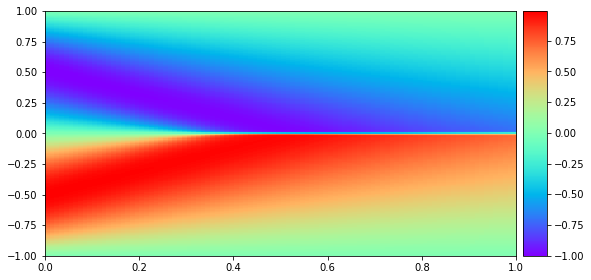

In [5]:
pinn.plot() #without points => to add if reused